In [1]:
import pandas as pd
from file_paths_and_consts import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
plt.style.use('classic')
import seaborn as sns
import geopandas as gpd
import random
sns.set()
import os
SEED_VALUE = 590
random.seed(SEED_VALUE)

OUTPUT_DIR

'/project/biocomplexity/UKR_forecast/migration_data/AAMAS_output_data/'

In [2]:
import multiprocessing as mp
import numpy as np
def calc_attitude_parallel(num):
    return num**2,num**3

def multiproc_attitude(all_nums):
    cpus = 4#mp.cpu_count()
    #st_time = time.time()
    hh_splits = np.array_split(all_nums, cpus) #--this a list with multiple dataframe.. each dataframe is used by one core
    #print(hh_splits)
    pool_args = [h_chunk for h_idx,h_chunk in enumerate(hh_splits)]
    #print('total time taken to split',time.time()-st_time)
    pool = mp.Pool(processes = cpus)
    results = pool.map(calc_attitude_parallel, pool_args)
    pool.close()
    pool.join()
    return results

ss = []

for i in range(0,100):
    ss.append(i)
    
results = multiproc_attitude(ss)
print(type(results[0][1]))

<class 'numpy.ndarray'>


In [3]:
pd.__version__

'1.1.0'

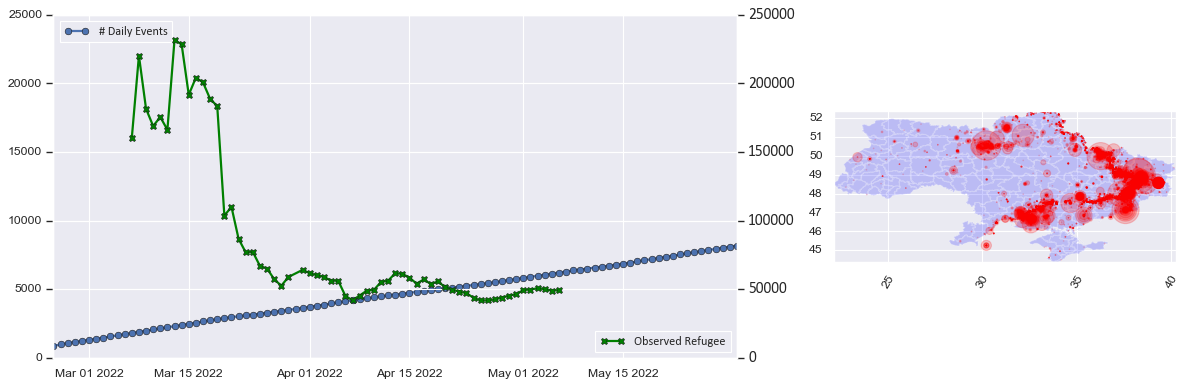

In [4]:
ROLLING = 7
conflict_data_file = UNCLEANED_DATA_DIR+'ukraine_conflict_data_feb_oct.csv'
refugee_data_file = GROUND_TRUTH_DIR+'ukraine_refugee_data_2.csv'
geo_shp_file = UNCLEANED_DATA_DIR+'UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp'

conflict_data = pd.read_csv(conflict_data_file)
conflict_data['time'] = pd.to_datetime(conflict_data['event_date'])
conflict_data = conflict_data.sort_values(by='time')
conflict_count = conflict_data[['time','fatalities']].groupby('time')['fatalities'].count().reset_index()
conflict_count['fatalities'] = conflict_count['fatalities'].cumsum()
conflict_count['fatalities'] = conflict_count['fatalities'].rolling(ROLLING).mean()
conflict_count = conflict_count.dropna(subset=['fatalities'])

refugee_data = pd.read_csv(refugee_data_file)
refugee_data['time'] = pd.to_datetime(refugee_data['time'])
refugee_data = refugee_data.sort_values(by='time')
refugee_data['refugee'] = refugee_data['refugee'].rolling(ROLLING).mean()
refugee_data = refugee_data.dropna(subset=['refugee'])
# refugee_data['refugee'] = refugee_data['refugee'].diff()
# refugee_data = refugee_data.dropna(subset=['refugee'])

burundi_gdf = gpd.read_file(geo_shp_file)

fig,ax = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'width_ratios': [2, 1]})
plt.xticks(rotation=60)
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 12
rcParams["axes.labelsize"] = 16
rcParams["axes.titlesize"] = 20
rcParams["xtick.labelsize"] = 14
rcParams["ytick.labelsize"] = 14

ax2 = ax[0].twinx()
ax2.plot(refugee_data['time'],refugee_data['refugee'],marker='X',linewidth=2,color='green',label='Observed Refugee')
ax[0].plot(conflict_count['time'],conflict_count['fatalities'],marker='o',linewidth=2,label='# Daily Events')
ax[0].set_xlim([datetime.date(2022, 2, 24), datetime.date(2022, 5, 31)])
#ax.set_ylim([conflict_count['fatalities'].min()-5,conflict_count['fatalities'].max()+5])
#ax2.set_ylim([refugee_data['refugee'].min()-500,refugee_data['refugee'].max()+500])
YLIM = [0,1000]
ax[0].legend(loc='upper left')
ax2.legend(loc='lower right')
#ax[0].set_ylim(YLIM)
fig.tight_layout()

burundi_gdf.plot(ax=ax[1],color='blue',alpha=0.2)
EPS = 0.1
SCALE = 2
conflict_data_gdf = gpd.GeoDataFrame(conflict_data,geometry=gpd.points_from_xy(conflict_data.longitude,conflict_data.latitude))
conflict_data_gdf.plot(ax=ax[1],color='red',alpha=0.2,markersize=(conflict_data['fatalities']+EPS)*SCALE)
ax[1].set_xlim(burundi_gdf.total_bounds[0], burundi_gdf.total_bounds[2])
ax[1].set_ylim(burundi_gdf.total_bounds[1], burundi_gdf.total_bounds[3])
fig.tight_layout()

In [5]:
all_ids = burundi_gdf['ADM2_EN'].tolist()

In [95]:
def get_results_for_2(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7,partition1 = 10,partition2 = 20,scale_1 = 1.0,scale_2 = 1.0,scale_3=1.0):
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        f2_name = prefix+'_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
        elif os.path.isfile(OUTPUT_DIR+f2_name):
            true_f_name = f2_name
        else:
            #print(cur_id,'not found')
            continue
            
        cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
        cur_df['time'] = pd.to_datetime(cur_df['time'])
        all_dfs.append(cur_df)
        found = found + 1
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    scale_list = [scale_1]*partition1+[scale_2]*(partition2-partition1)+[scale_3]*(ovr_df.shape[0]-partition2)
    ovr_df['scale'] = scale_list
    ovr_df[who] = ovr_df[who]*ovr_df['scale']
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(found,'raions found')
    return ovr_df

def get_raion_list(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7):
    
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
            all_dfs.append(cur_id)
        else:
            continue
            
    return set(all_dfs)

#get_results_for(777,prefix='mim')
def get_uncertainty_results(hyper_comb, region_name="all",prefix='fresh_calib_batch_simulation'):
    all_dfs = []
    if region_name=="all":
        col_to_sum = ['refugee','old_people','child','male','female']
        for cur_id in all_ids:
            f_name = prefix+'_result_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
            if os.path.isfile(OUTPUT_DIR+f_name):
                cur_df = pd.read_csv(OUTPUT_DIR+f_name)
                cur_df['time'] = pd.to_datetime(cur_df['time'])
                cur_df = cur_df.sort_values(by=['time','refugee'],ascending=[True,False])
                
                cur_df = cur_df.drop_duplicates(subset=['time'],keep='first')
                all_dfs.append(cur_df)
    return all_dfs

In [96]:
# ## compare if result looks same for a raion against two runs
# df1 = get_results_for_2(99950,region_name=['Kyiv'],prefix='mim_result')
# df2 = get_results_for_2(99969,region_name=['Kyiv'],prefix='mim_result')

# rcParams["font.family"] = "calibri"
# rcParams["font.size"] = 32
# rcParams["axes.labelsize"] = 28
# rcParams["axes.titlesize"] = 28
# rcParams["xtick.labelsize"] = 26
# rcParams["ytick.labelsize"] = 26

# fig,ax = plt.subplots(figsize=(14,5))
# plt.xticks(rotation=30)

# ax.plot(df1['time'],df1['refugee'],label='99950')
# ax.plot(df2['time'],df2['refugee'],label='99960')

# ax.set_xlim([datetime.date(2022, 3, 7), datetime.date(2022, 5, 6)])
# ax.legend(loc='best')
# df1['refugee'].corr(df2['refugee'])


In [97]:
r1 = get_raion_list(99950,prefix='mim_result')
r2 = get_raion_list(500,prefix='mim_result')
r1-r2

set()

In [98]:
# HOUSEHOLD_DATA_PREFIX = 'ukraine_household_data_ADM2_HDX.csv'
# hh_df = pd.read_csv(HOUSEHOLD_DIR+HOUSEHOLD_DATA_PREFIX)
# hh_df.shape

In [99]:
# hh_cnt = hh_df['matching_place_id'].value_counts().reset_index().rename(columns={'index':'raion','matching_place_id':'hh'})

In [100]:
r1 = list(get_raion_list(10000,prefix='mim_result'))
print(len(r1))

119


In [101]:
hh_cnt = pd.read_csv('hh_cnts.csv')

## UNCERTAINTY PLOTS FOR 

#### Create the data

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.style.use('classic')
import seaborn as sns
sns.set()

def get_uncertainty(sim_indices,first_df,q1=0.25,q3=0.75):
    #first_df = first_df[0:sz]
    run_cols = [str(i) for i in sim_indices if str(i) in first_df.columns.tolist()]
    medians = first_df[run_cols].median(axis=1)
    q1 = first_df[run_cols].quantile(q1, axis=1)
    q3 = first_df[run_cols].quantile(q3, axis=1)
    return medians,q1,q3

#simulation_indices = [10060,10061,10062,10063,10064,10065,10066,10067,10068,10069]
#simulation_indices = [30000,30001,30002,30003,30004,30005,30006]
#simulation_indices = [40000,40001,40002,40003,40004,40005,40006]
#simulation_indices = [50000,50001,50002,50003,50004,50005,50006]
#simulation_indices = [50006,50007,50008,50009,50010,50011]
#simulation_indices = [2000,2001,2004,2005]


In [103]:
import json

samples = []
with open('./logs/bayes_examples_all_log_revised.json', 'r') as file:
    for line in file:
        samples.append(json.loads(line))

good = []
max_err = -40000

for i in range(0,len(samples)):
    tt = samples[i]['target']
    if tt>max_err:
        good.append(i)
print(good)

[18, 19, 20, 21]


In [104]:
# rmse_1 = []
# rmse_2 = []



# for i in range(0,len(good)):
#     res = get_results_for_2(5000+good[i],prefix='mim_result',partition=20,scale_1=1.0,scale_2=1.0)
#     comp_df = res.merge(refugee_data,on='time',how='inner')
#     comp_df['diff'] = (comp_df['refugee_y']-comp_df['refugee_x'])**2
#     rmse = ((comp_df[5:10]['diff'].sum()+comp_df[50:55]['diff'].sum())/10)**0.5 #10 data points
#     rmse_full = ((comp_df['diff'].sum())/comp_df.shape[0])**0.5 #10 data points
#     rmse_1.append(rmse)
#     rmse_2.append(rmse_full)
#     print(good[i],rmse,rmse_full)
#     #ax.plot(rmse,rmse)


In [130]:
import warnings
warnings.filterwarnings('ignore')

#simulation_indices = [100,110,111,112,113,114]
#simulation_indices = [115,116,117,118,119]
#simulation_indices = [120,121,122,123,124,125,126,127,128,129,130]
#simulation_indices = [1001,1002,1004,1009]
#simulation_indices = [100,101,102,105]
simulation_indices = [i for i in range(10000+30,10000+36)]
first_df = []
second_df = []

for vv in simulation_indices:
    
        print(vv,end=' ')
        current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING,partition1=10,partition2=50,scale_1=0.6,scale_2=1.0,scale_3=2.0)
        #current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING,partition=20,scale_1=1.2,scale_2=1.5)
        current_df['comb'] = str(vv)
        #current_df_unsmoothed = get_results_for(vv,prefix='mim_result',ROLL=1)
        #current_df_unsmoothed['comb'] = str(vv)

        first_df.append(current_df)
    
        #continue
    #second_df.append(current_df_unsmoothed)
first_df = pd.concat(first_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)
#print(first_df.head())
# mm = 1.5
# ss = 38
# for col in simulation_indices:
#     first_df[str(col)][ss:] = first_df[str(col)][ss:]*mm
    #print(first_df.head())
#second_df = pd.concat(second_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

10030 120 raions found
10031 120 raions found
10032 120 raions found
10033 120 raions found
10034 120 raions found
10035 120 raions found


In [131]:
refugee_data_2 = pd.read_csv('../ABM_model_Ukraine/ukr_refugee_src_2.csv')
refugee_data_2['time'] = pd.to_datetime(refugee_data_2['time'])
refugee_data_2 = refugee_data_2.sort_values(by='time')
refugee_data_2['refugee'] = refugee_data_2['daily'].rolling(ROLLING).mean()
refugee_data_2 = refugee_data_2.dropna(subset=['refugee'])
# refugee_data['refugee'] = refugee_data['refugee'].diff()
# refugee_data = refugee_data.dropna(subset=['refugee'])
#refugee_data_2 = refugee_data_2[refugee_data_2.time>pd.to_datetime('2022-05-05')]
#refugee_data_2.at[71, 'refugee'] = 49355.571429

refugee_data_2

,time,cumulative,daily,refugee
6,2022-03-02,989560,170799,141365.714286
7,2022-03-03,1173690,184130,156354.428571
8,2022-03-04,1343790,170100,166323.571429
9,2022-03-05,1540463,196673,173957.571429
10,2022-03-06,1742987,202524,178936.285714
...,...,...,...,...
90,2022-05-25,6652164,48379,46706.285714
91,2022-05-26,6700411,48247,46780.428571
92,2022-05-27,6737208,36797,44601.142857
93,2022-05-28,6771963,34755,42605.428571


In [132]:
first_df

comb,time,10030,10031,10032,10033,10034,10035
0,2022-03-02,85534.628571,95697.857143,92065.114286,95418.942857,96865.285714,8.940669e+04
1,2022-03-03,103038.171429,115056.257143,110041.885714,114419.142857,116954.228571,1.069179e+05
2,2022-03-04,138603.771429,154176.942857,145977.171429,153318.428571,158291.914286,1.420137e+05
3,2022-03-05,172090.542857,191492.228571,180819.257143,190003.028571,197184.857143,1.757604e+05
4,2022-03-06,232713.200000,258765.114286,243550.457143,256024.657143,266703.200000,2.360307e+05
...,...,...,...,...,...,...,...
193,2022-09-11,0.000000,0.000000,0.000000,0.000000,0.000000,6.652304e-11
194,2022-09-12,4.857143,7.714286,7.142857,7.714286,4.571429,7.714286e+00
195,2022-09-13,4.857143,7.714286,7.142857,7.714286,4.571429,7.714286e+00
196,2022-09-14,4.857143,7.714286,7.142857,7.714286,4.571429,7.714286e+00


In [133]:
# refugee_data_full = pd.read_csv('ukr_refugee_full.csv')
# refugee_data_full['refugee'] = refugee_data_full['Cumulative Refugees'].diff()
# refugee_data_full = refugee_data_full.dropna(subset=['refugee'])
# refugee_data_full['time'] = pd.to_datetime(refugee_data_full['Date'])
# refugee_data_full = refugee_data_full.sort_values(by='time')
# refugee_data_full['refugee'] = refugee_data_full['refugee'].rolling(ROLLING).mean()
# refugee_data_full = refugee_data_full.dropna(subset=['refugee'])
# #refugee_data_full
# # refugee_data_2['time'] = pd.to_datetime(refugee_data_2['time'])
# # refugee_data_2 = refugee_data_2.sort_values(by='time')
# # refugee_data_2['refugee'] = refugee_data_2['daily'].rolling(ROLLING).mean()
# # refugee_data_2 = refugee_data_2.dropna(subset=['refugee'])
# # # refugee_data['refugee'] = refugee_data['refugee'].diff()
# # # refugee_data = refugee_data.dropna(subset=['refugee'])
# # refugee_data_2

## Do specifying different cores and memory change result apart from stochasticity?

In [134]:
refugee_data['refugee'].sum()

5160175.142857144

10030 10031 10032 10033 10034 10035 

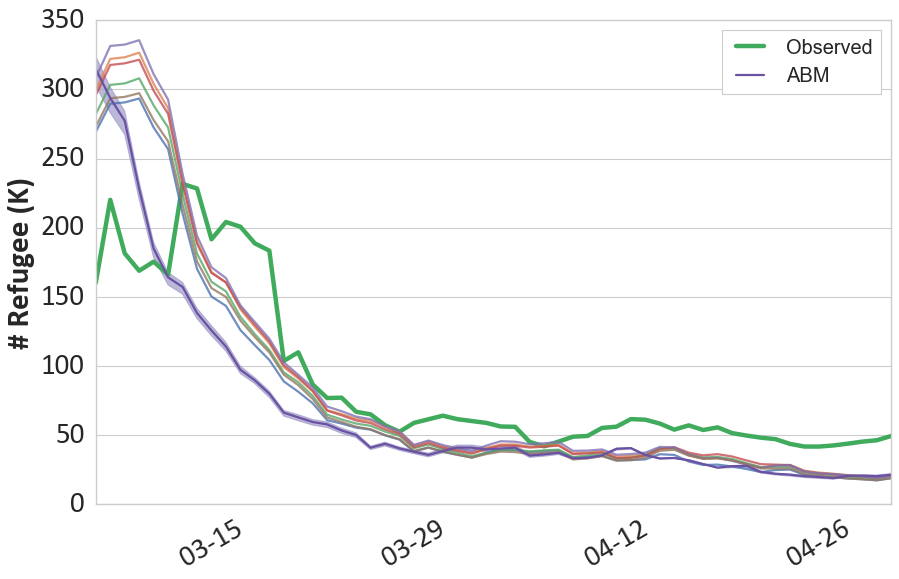

In [135]:
import datetime

trim = 7

#good = []

median_normal,q1_normal,q3_normal = get_uncertainty(simulation_indices,first_df,q1=0.3,q3=0.7)
# median_esc,q1_esc,q3_esc = get_uncertainty(simulation_indices[10:-trim],first_df)

# median_normal_unsmooth,q1_normal_unsmooth,q3_normal_unsmooth = get_uncertainty(simulation_indices[0:10-trim],second_df)
# median_esc_unsmooth,q1_esc_unsmooth,q3_esc_unsmooth = get_uncertainty(simulation_indices[10:-trim],second_df)

# median_normal,q1_normal,q3_normal = get_uncertainty([check_single],first_df)
# median_esc,q1_esc,q3_esc = get_uncertainty([check_single+1],first_df)
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

fig,ax = plt.subplots(figsize=(12,8))
plt.xticks(rotation=30)

ax.plot(refugee_data['time'], refugee_data['refugee']/1000,label='Observed',linewidth=4,color='#41ab5d')
#ax.plot(refugee_data_full['time'], refugee_data_full['refugee']/1000,label='Observed 2',linewidth=8,color='black')
#ax.plot(refugee_data_2['time'], refugee_data_2['refugee']/1000,label='Observed 2',linewidth=4,color='#2ca25f')
#l_vals = [-0.1,0.5,0.6,0.7,0.8,0.9]
#l_vals = [0.1,0.05,0.01,0.001,0.2]
#l_vals = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.01,0.99]
l_vals = simulation_indices
#l_vals = [0.9,0.8,0.2,0.5]
for idx,p in enumerate(simulation_indices):
    print(p,end=' ')
    try:
        new_series = first_df[str(p)].copy()
        #if new_series.max()>250000:
        #    continue
        #if new_series[0:10].min()<100000:
        #    continue
        ax.plot(first_df['time'],new_series/1000,linewidth=2,alpha=0.8)
    except Exception as e:
        print(e)
        continue
sns.set_style('white')
SHIFT = -3
ax.plot(first_df['time'][0:SHIFT],median_normal.shift(SHIFT)[0:SHIFT]/1000,linewidth=2,color='#6a51a3',alpha=1,label='ABM')
ax.fill_between(first_df["time"][0:SHIFT], q1_normal.shift(SHIFT)[0:SHIFT]/1000, q3_normal.shift(SHIFT)[0:SHIFT]/1000, color='#9e9ac8',alpha=0.7)

myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(myFmt)

#ax.set_facecolor("white")
sns.set_style('whitegrid')

ax.legend(loc='best',ncol=1,fontsize=18)
ax.set_ylabel("# Refugee (K)",fontweight='bold')
ax.set_xlim([datetime.date(2022, 3, 7), datetime.date(2022, 5, 1)])
#ax.set_ylim([0,300])
ax.grid(axis='x')
#print(ax.get_xticks())
fig.tight_layout()
#fig.savefig('../Figures/iaai_abm_result.pdf',dpi=350,bbox_inches='tight')
#5110 porjonto bhalo

10013 10014 10015 10016 

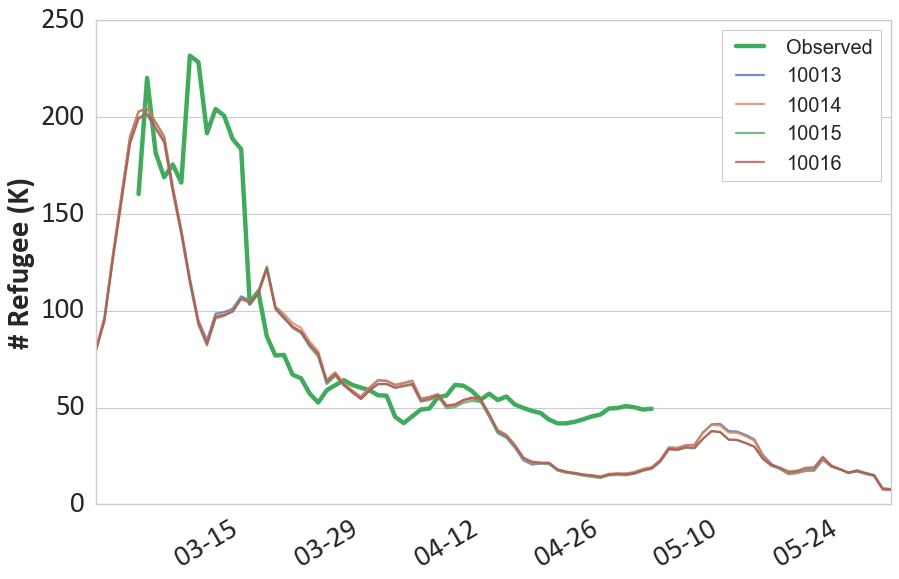

In [37]:
import datetime

trim = 7

#good = []

median_normal,q1_normal,q3_normal = get_uncertainty(simulation_indices,first_df,q1=0.3,q3=0.7)
# median_esc,q1_esc,q3_esc = get_uncertainty(simulation_indices[10:-trim],first_df)

# median_normal_unsmooth,q1_normal_unsmooth,q3_normal_unsmooth = get_uncertainty(simulation_indices[0:10-trim],second_df)
# median_esc_unsmooth,q1_esc_unsmooth,q3_esc_unsmooth = get_uncertainty(simulation_indices[10:-trim],second_df)

# median_normal,q1_normal,q3_normal = get_uncertainty([check_single],first_df)
# median_esc,q1_esc,q3_esc = get_uncertainty([check_single+1],first_df)
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

fig,ax = plt.subplots(figsize=(12,8))
plt.xticks(rotation=30)

ax.plot(refugee_data['time'], refugee_data['refugee']/1000,label='Observed',linewidth=4,color='#41ab5d')
#ax.plot(refugee_data_full['time'], refugee_data_full['refugee']/1000,label='Observed 2',linewidth=8,color='black')
#ax.plot(refugee_data_2['time'], refugee_data_2['refugee']/1000,label='Observed 2',linewidth=4,color='#2ca25f')
#l_vals = [-0.1,0.5,0.6,0.7,0.8,0.9]
#l_vals = [0.1,0.05,0.01,0.001,0.2]
#l_vals = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.01,0.99]
l_vals = simulation_indices
#l_vals = [0.9,0.8,0.2,0.5]
for idx,p in enumerate(simulation_indices[0:4]):
    print(p,end=' ')
    try:
        new_series = first_df[str(p)].copy()
        #if new_series.max()>250000:
        #    continue
        #if new_series[0:10].min()<100000:
        #    continue
        ax.plot(first_df['time'],new_series/1000,linewidth=2,alpha=0.8,label=str(l_vals[idx]))
    except Exception as e:
        print(e)
        continue
sns.set_style('white')
SHIFT = -1
#ax.plot(first_df['time'][0:SHIFT],median_normal.shift(SHIFT)[0:SHIFT]/1000,linewidth=2,color='#6a51a3',alpha=1,label='ABM')
#ax.fill_between(first_df["time"][0:SHIFT], q1_normal.shift(SHIFT)[0:SHIFT]/1000, q3_normal.shift(SHIFT)[0:SHIFT]/1000, color='#9e9ac8',alpha=0.7)

myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(myFmt)

#ax.set_facecolor("white")
sns.set_style('whitegrid')

ax.legend(loc='best',ncol=1,fontsize=18)
ax.set_ylabel("# Refugee (K)",fontweight='bold')
ax.set_xlim([datetime.date(2022, 3, 2), datetime.date(2022, 6, 3)])
#ax.set_ylim([0,300])
ax.grid(axis='x')
#print(ax.get_xticks())
fig.tight_layout()
#fig.savefig('../Figures/iaai_abm_result.pdf',dpi=350,bbox_inches='tight')
#5110 porjonto bhalo

In [20]:
first_df['median'] = median_normal
first_df['q1'] = q1_normal
first_df['q3'] = q3_normal

compare_df = first_df.merge(refugee_data,on='time',how='inner')

In [21]:
compare_df['median'] = compare_df['median'].shift(-2)
compare_df['q1'] = compare_df['q1'].shift(-2)
compare_df['q3'] = compare_df['median'].shift(-2)
for pp in simulation_indices:
    compare_df[str(pp)] = compare_df[str(pp)].shift(-2)
compare_df = compare_df.dropna(subset=['median'])

In [22]:
pcc = compare_df['median'].corr(compare_df['refugee'])
print(pcc)
mse = (((compare_df['median'] - compare_df['refugee'])**2).sum()/compare_df.shape[0])**0.5
print(mse)

0.8434954234449211
67079.528549917


In [153]:
all_pccs = []
for pp in simulation_indices:
    pcc = compare_df[str(pp)].corr(compare_df['refugee'])
    print(pcc)
    if pcc>0.88:
        all_pccs.append(pcc)

0.860765886917243
0.8987159295045842
0.7683944480314154
0.8287345305634838
0.7728786057106194
0.7353337150052047
0.8597790605813531
0.8915307072531432
0.8984367445290472
0.9243156994397533
0.8557041705271105
0.9084574116622917
0.8398722747095633
0.8962103460730613
0.8454012797060692
0.7455675026940237
0.8616899390286963
0.9125752737794215
0.8709092218811045
0.9334811321196066
0.8782703994433936
0.8986987965879706
0.7446444099615933
0.8590325815132912
0.8558078594054305
0.7901102024083757
0.9037952258529238
0.6782143123484123
0.7864003033608173
0.8895350062965933
0.7959853476839477
0.8877577360671317
0.7942512423253698
0.8581817225120458
0.8358008228506909
0.8339745091195945
0.9145183547004758
0.878039252514925
0.8690939303088528
0.9147221941751347
0.9353947254481919
0.6708233228605877
0.8132119385359339
0.9129985930925596
0.8970043470077469
0.8943600563029859


In [158]:
all_mses = []
for pp in simulation_indices:
    mse = (((compare_df[str(pp)] - compare_df['refugee'])**2).sum()/compare_df.shape[0])**0.5
    print(mse)
    if mse<32000:
        all_mses.append(mse)

35425.978904760734
52883.61188158919
43754.54333328734
43092.43717143575
48016.10614428359
44163.75359880803
39423.94692952868
37288.709529523185
34554.969894054426
24539.02778404916
57562.66945474869
32096.015238128428
34388.477270421114
49029.380402793664
41143.66635043969
42433.358787559024
39987.9644577294
27700.886543150675
34557.73895434407
35163.83856820145
43462.02899779328
41684.98086602946
65544.95595296776
38579.33264285433
38049.16305919334
56451.57436375326
35916.321620279894
43494.23354748379
57127.83105965419
55442.44505940405
44117.119448328755
50104.05724021057
43287.15999460748
45525.220378913196
40885.28103213951
34742.00746470063
36520.41028656212
41380.066355094976
35105.94255487863
34266.0037701278
39751.31698511881
69696.84200528276
50824.67369998382
25760.191243800058
37841.634439155525
43142.68318897583


In [159]:
all_mses

[24539.02778404916, 27700.886543150675, 25760.191243800058]

In [156]:
sum(all_mses)/len(all_mses)

26000.035190333296

In [157]:
np.std(all_mses)

1301.9169308224493

In [ ]:
(compare_df['median']-compare_df['refugee'])

In [61]:
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['median'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['q1'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['q3'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-03-01')) & (compare_df.time<=pd.to_datetime('2022-03-31'))]['refugee'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['median'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['refugee'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['q1'].sum()
compare_df[(compare_df.time>=pd.to_datetime('2022-04-01')) & (compare_df.time<=pd.to_datetime('2022-04-30'))]['q3'].sum()
compare_df['q1'].sum()
compare_df['q3'].sum()

3400824.6428571427

## Compare with food prices

In [73]:
# food_df = pd.read_csv(UNCLEANED_DATA_DIR+'wfp_food_prices_ukr.csv')
# #food_df['commodity'].unique().tolist()
# food_df['date'] = pd.to_datetime(food_df['date'])

# for food in food_df['commodity'].unique().tolist():
#     cur_food_price = food_df[food_df.commodity==food]
    

## compare_everything

In [75]:
x = 7275283.098597599
y = 5523150.002945037
z = 1616600.5681473766
a = 10305552.99151849
b = 7887347.678246012
c = 2202283.6001177765

In [76]:
x_axis = ['Overall','March','April']
Method = ['Observed','ABM','Pandey']
colors = ['#41ab5d','#6a51a3','#ae017e']
values = [[5160175,3321159,1540624],[4917812,3400824,1266664],[8519858,6484278,1881154]]
errmin = [[0,0,0],[values[1][0]-3990658,values[1][1]-2878165,values[1][2]-907943],[values[2][0]-x,values[2][1]-y,values[2][2]-z]]
errmax = [[0,0,0],[6137919-values[1][0],4123093-values[1][1],1711786-values[1][2]],[a-values[2][0],b-values[2][1],c-values[2][2]]]

In [77]:
print(errmin)
print(errmax)

[[0, 0, 0], [927154, 522659, 358721], [1244574.9014024008, 961127.9970549634, 264553.43185262335]]
[[0, 0, 0], [1220107, 722269, 445122], [1785694.99151849, 1403069.678246012, 321129.60011777654]]


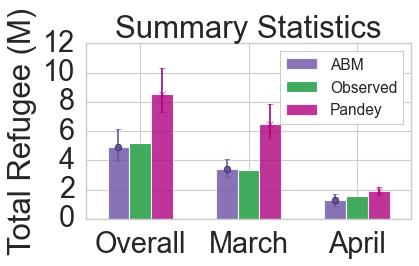

In [105]:
# Numbers of pairs of bars you want
N = len(x_axis)

truth_bar = values[0]
abm_bar = values[1]
pandey_bar = values[2]

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
fig,ax = plt.subplots(figsize=(6,4))

# Width of a bar 
width = 0.2       

# Plotting
ax.bar(ind - width, np.array(abm_bar)/1e6 , width, label='ABM',color=colors[1],alpha=0.8)
ax.errorbar(ind - width, np.array(abm_bar)/1e6, yerr = [np.array(errmin[1])/1e6,np.array(errmax[1])/1e6],fmt='o',color=colors[1])

ax.bar(ind, np.array(truth_bar)/1e6 , width, label='Observed',color=colors[0])

ax.bar(ind + width, np.array(pandey_bar)/1e6 , width, label='Pandey',color=colors[2],alpha=0.8)
ax.errorbar(ind + width, np.array(pandey_bar)/1e6, yerr = [np.array(errmin[2])/1e6,np.array(errmax[2])/1e6],fmt='x',color=colors[2])

ax.set_ylabel('Total Refugee (M)')

ax.set_title('Summary Statistics')

ax.set_xticks(ind)
ax.set_xticklabels(x_axis)
ax.set_yticks
# Finding the best position for legends and putting it
ax.legend(loc='best',fontsize=14,ncol=1)
ax.set_ylim([0,12])
fig.tight_layout()
fig.savefig('../Figures/summary_stat.pdf',dpi=350,bbox_inches='tight')

In [93]:
[errmin[1],errmax[1]]

[[927154, 522659, 358721], [1220107, 722269, 445122]]

In [81]:
np.array(abm_bar)/1e6

array([4.917812, 3.400824, 1.266664])

In [51]:
all_dfs = []
for region in all_ids:
    print(region,end=' ')
    try:
        cur_df = get_results_for_2(5000+101, who='refugee',region_name=[region],prefix='mim_result',partition = 20,scale_1 = 1.2,scale_2 = 1.5)
        cur_df['raion'] = region
        all_dfs.append(cur_df)
        #break
    except:
        print('chesta')
        continue

Bakhchysaraiskyi 1 raions found
Bilohirskyi 1 raions found
Dzhankoiskyi 1 raions found
Yevpatoriiskyi 1 raions found
Kerchynskyi 1 raions found
Krasnohvardiiskyi chesta
Krasnoperekopskyi chesta
Simferopolskyi 1 raions found
Feodosiiskyi 1 raions found
Yaltynskyi chesta
Vinnytskyi 1 raions found
Haisynskyi chesta
Zhmerynskyi 1 raions found
Mohyliv-Podilskyi chesta
Tulchynskyi chesta
Khmilnytskyi 1 raions found
Volodymyrskyi 1 raions found
Kamin-Kashyrskyi 1 raions found
Kovelskyi chesta
Lutskyi 1 raions found
Dniprovskyi 1 raions found
Kamianskyi 1 raions found
Kryvorizkyi 1 raions found
Nikopolskyi 1 raions found
Novomoskovskyi 1 raions found
Pavlohradskyi 1 raions found
Synelnykivskyi 1 raions found
Bakhmutskyi 1 raions found
Volnovaskyi 1 raions found
Horlivskyi 1 raions found
Donetskyi 1 raions found
Kalmiuskyi 1 raions found
Kramatorskyi 1 raions found
Mariupolskyi 1 raions found
Pokrovskyi 1 raions found
Berdychivskyi 1 raions found
Zhytomyrskyi 1 raions found
Korostenskyi 1 raion

In [53]:
pivot_df = pd.concat(all_dfs).pivot(index='raion',columns='time',values='refugee')
each_day_max_raion = pivot_df.idxmax().reset_index()

In [55]:
each_day_max_raion[0].value_counts()

Zaporizkyi      32
Kramatorskyi    12
Alchevskyi       8
Kyiv             8
Kryvorizkyi      8
Chuhuivskyi      7
Kharkivskyi      7
Mykolaivskyi     5
Khersonskyi      5
Donetskyi        2
Name: 0, dtype: int64

In [99]:
def assign_raion_to_dest(hyper_comb, raion, who='refugee',prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7,partition = 40,scale_1 = 1.2,scale_2 = 1.5):
    all_dfs = []
    f_name = prefix+'_completed_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    f2_name = prefix+'_'+str(raion)+'_'+str(hyper_comb).zfill(5)+'.csv'
    #print(f_name)
    if os.path.isfile(OUTPUT_DIR+f_name):
        true_f_name = f_name
    elif os.path.isfile(OUTPUT_DIR+f2_name):
        true_f_name = f2_name

    cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
    cur_df['time'] = pd.to_datetime(cur_df['time'])
    all_dfs.append(cur_df)
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    scale_list = [scale_1]*partition+[scale_2]*(ovr_df.shape[0]-partition)
    ovr_df['scale'] = scale_list
    ovr_df[who] = ovr_df[who]*ovr_df['scale']
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(ovr_df[who].sum(),end=' ')
    #dest_df = pd.read_csv(BASE_DIR+'destination_data/destination_rij_eu_only_minus_Romania_stock_only_'+str(raion)+'.csv')
    dest_df = pd.read_csv(BASE_DIR+'destination_data/destination_rij_stock_only_eu_only_'+str(raion)+'.csv')
    ovr_df['key'] = 1
    dest_df['key'] = 1
    raion_to_dest = ovr_df[['time','refugee','key']].merge(dest_df[['Country','rij','key']],on='key',how='inner')
    raion_to_dest['flow'] = raion_to_dest['refugee']*raion_to_dest['rij']
    print(raion_to_dest['flow'].sum(),raion)
    raion_to_dest['from'] = raion
    return raion_to_dest

In [100]:
all_dests = []

for raion in all_ids:
    try:
        dest_raion_df = assign_raion_to_dest(5000+101,raion,prefix='mim_result')
        all_dests.append(dest_raion_df)
    except:
        continue

1337.485714285715 1337.485714285715 Bakhchysaraiskyi
26.4 26.4 Bilohirskyi
150.9 150.9 Dzhankoiskyi
165.59999999999997 165.59999999999997 Yevpatoriiskyi
277.5 277.5 Kerchynskyi
3431.0999999999995 3431.1 Simferopolskyi
120.0 120.0 Feodosiiskyi
16826.571428571435 16826.571428571428 Vinnytskyi
1351.5 1351.4999999999998 Zhmerynskyi
328.5 328.49999999999994 Khmilnytskyi
152.4 152.39999999999998 Volodymyrskyi
10.799999999999999 10.799999999999997 Kamin-Kashyrskyi
6888.3 6888.3 Lutskyi
63215.74285714286 63215.74285714286 Dniprovskyi
265.2 265.2 Kamianskyi
375983.9142857143 375983.91428571433 Kryvorizkyi
18583.842857142852 18583.842857142856 Nikopolskyi
477.0 477.0 Novomoskovskyi
3105.814285714286 3105.8142857142866 Pavlohradskyi
1775.0571428571427 1775.057142857143 Synelnykivskyi
68638.28571428574 68638.28571428575 Bakhmutskyi
72995.87142857142 72995.87142857145 Volnovaskyi
263723.3999999996 263723.3999999997 Horlivskyi
505756.41428571334 505756.41428571334 Donetskyi
63817.45714285707 63817.4

In [101]:
all_flow_from_all_raion = pd.concat(all_dests)
all_flow_from_all_raion.groupby('Country')['flow'].sum().reset_index().sort_values(by='flow',ascending=False)

,Country,flow
19,Poland,1.950578e+06
14,Italy,9.055663e+05
10,Germany,7.335411e+05
5,Czech Republic,5.643315e+05
12,Hungary,3.730222e+05
21,Romania,3.225132e+05
24,Spain,2.221435e+05
11,Greece,1.927058e+05
7,Estonia,1.826178e+05
2,Bulgaria,1.458914e+05


In [85]:
raion_df = get_results_for_2(5000+101,region_name=['Kyiv'],prefix='mim_result')
print(raion_df['refugee'].sum())
dest_df = pd.read_csv(BASE_DIR+'destination_data/destination_rij_eu_only_minus_Romania_'+str('Kyiv')+'.csv')
dest_df['rij'].sum()
raion_df['key'] = 1
dest_df['key'] = 1
raion_to_dest = raion_df[['time','refugee','key']].merge(dest_df[['Country','rij','key']],on='key',how='inner')
raion_to_dest['flow'] = raion_to_dest['refugee']*raion_to_dest['rij']
print(raion_to_dest['flow'].sum())

1 raions found
358943.28571428574
357090.9346861782
